In [1]:
import unWISE_bincount_maps as ubm
import os
import numpy as np
import healpy as hp
# Load the unWISE bincount maps

COMBINED = '/mnt/d/data_large/unwise_sz/unWISE/blue_bincounts_combined/'
mapsPaths = os.listdir(COMBINED)

for mapPath in mapsPaths:
    print(mapPath)

numcount_map.fits
w1_map.fits
w2_map.fits


In [2]:
NSIDE = 2048

numcounts = hp.read_map(COMBINED + 'numcount_map.fits')
flux_w1 = hp.read_map(COMBINED + 'w1_map.fits')
flux_w2 = hp.read_map(COMBINED + 'w2_map.fits')



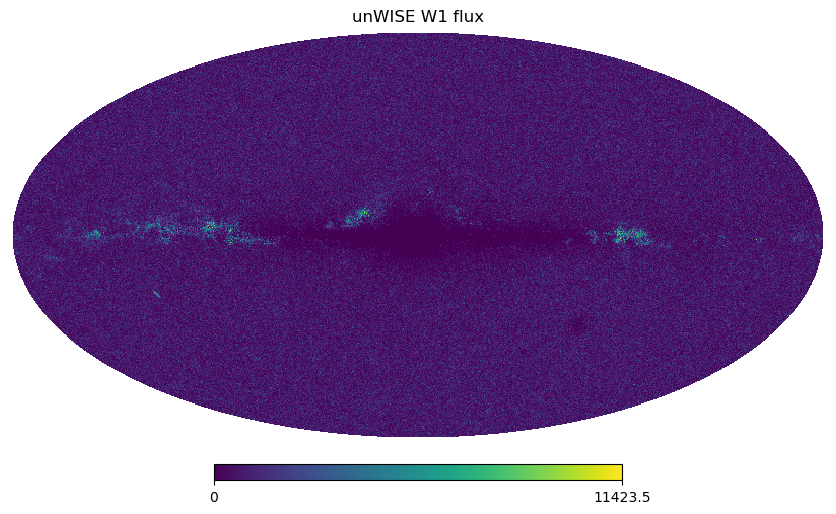

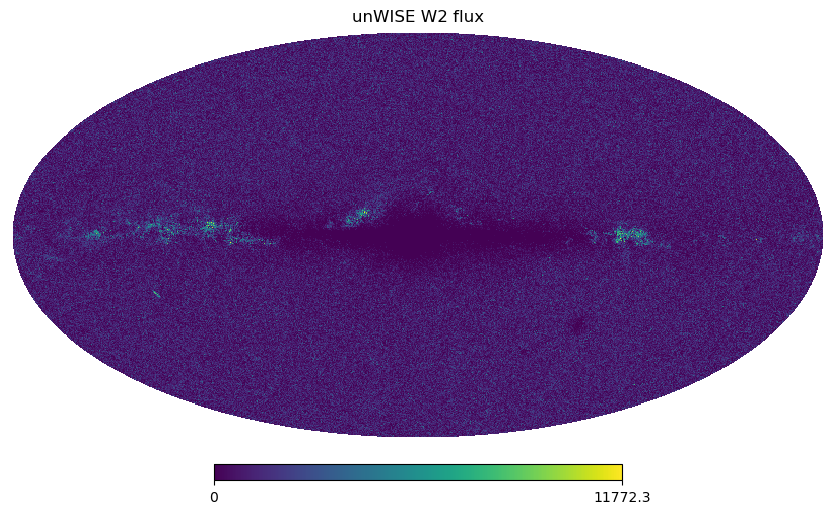

In [3]:
hp.mollview(flux_w1, title='unWISE W1 flux')
hp.mollview(flux_w2, title='unWISE W2 flux')

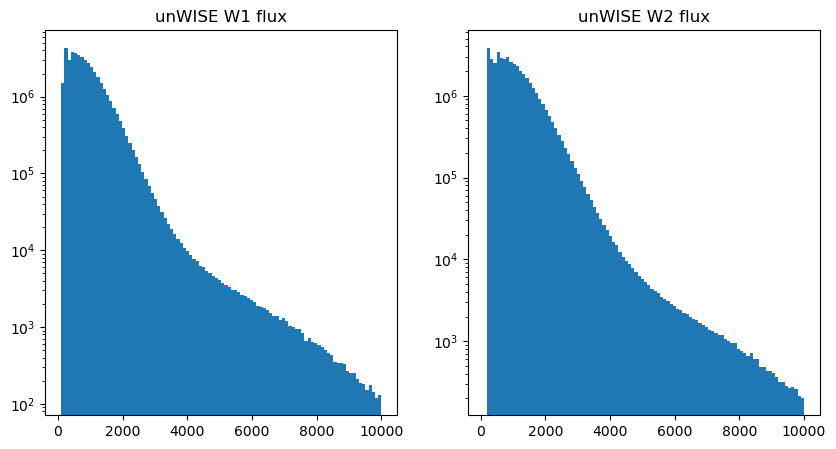

In [4]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].hist(flux_w1[flux_w1>0],bins=100,log=True,range=(1e2,1e4))
ax[0].set_title('unWISE W1 flux')
ax[1].hist(flux_w2[flux_w2>0],bins=100,log=True,range=(1e2,1e4))
ax[1].set_title('unWISE W2 flux')
plt.show()

In [5]:
def nan_divide(a, b):
    c = np.zeros_like(a)
    c[b>0] = a[b>0] / b[b>0]
    return c

c12 = nan_divide(flux_w1,flux_w2)
c12[c12==0] = hp.UNSEEN

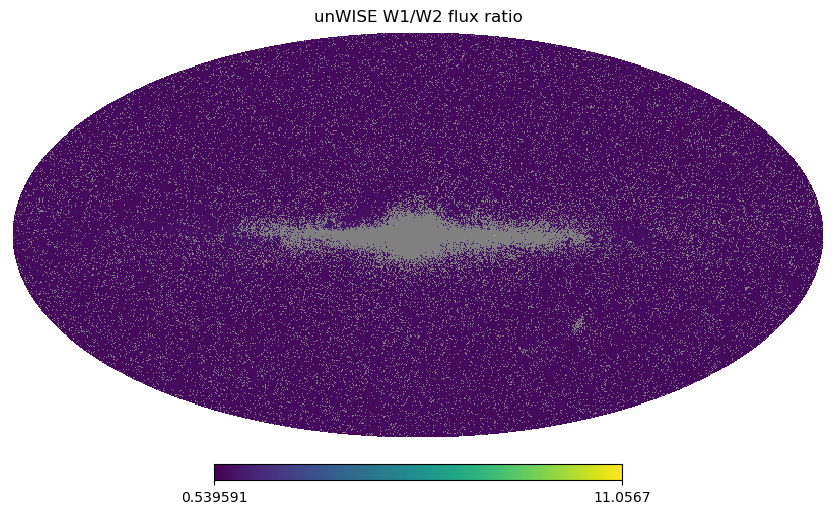

In [6]:
hp.mollview(c12, title='unWISE W1/W2 flux ratio')

In [7]:
from astropy.io import fits

DAT = '/mnt/d/data_large/unwise_sz/'
PATHMAP = DAT + 'unWISE/'

print('Reading mask...')
mask = hp.read_map(PATHMAP+'mask/mask_unWISE_full_v10.fits')
lost = fits.open(PATHMAP+"loss/unmaskedareafrac-flag.fits")
map_lost = lost[0].data
# invalid = (mask_lost == 0)

# galmask = mask * invalid

Reading mask...


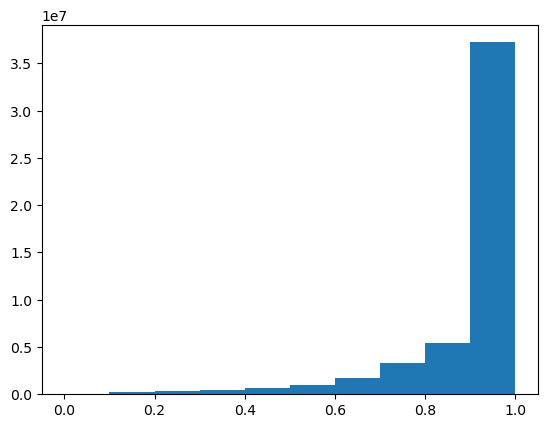

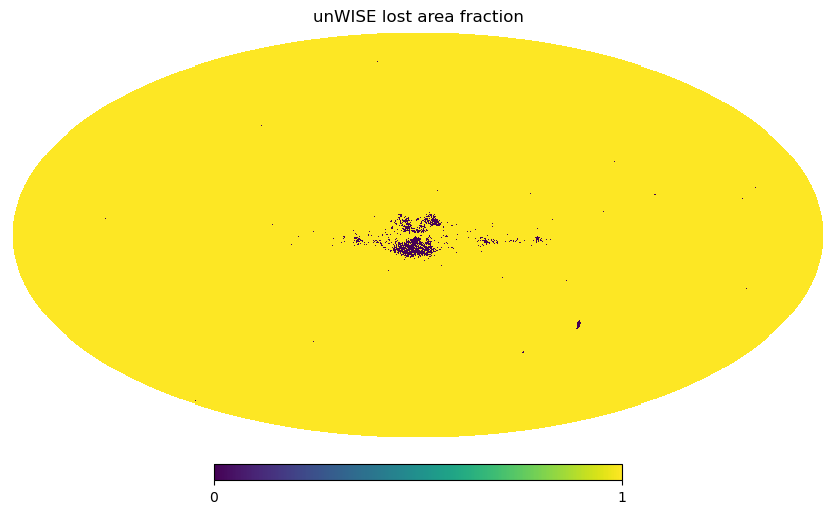

In [8]:
plt.hist(map_lost)
hp.mollview(map_lost>0.2, title='unWISE lost area fraction')

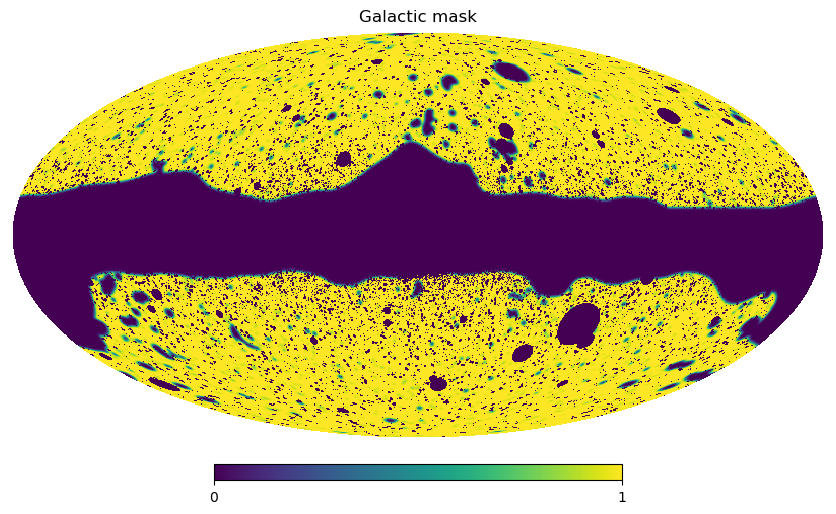

In [9]:
# hp.mollview(hp.read_map(PATHMAP+'mask/mask_unWISE_full_v10.fits'), title='Galactic mask')
galmask = hp.read_map(PATHMAP+'mask/mask_unWISE_full_v10.fits')
hp.mollview(galmask, title='Galactic mask')

In [10]:
c12 = -2.5*np.log10(nan_divide(flux_w1,flux_w2))

DAT = '/mnt/d/data_large/unwise_sz/'
PATHMAP = DAT + 'unWISE/'
galmask = hp.read_map(PATHMAP+'mask/mask_unWISE_full_v10.fits')
galmask = (galmask>0.9) #  & (flux_w1>10) & (flux_w2>10)
masked_c12 = c12[galmask]
masked_Lw1 = flux_w1[galmask]
mag_Lw1 = 22.5-2.5*np.log10(masked_Lw1)

masked_Lw2 = flux_w2[galmask]
mag_Lw2 = 22.5-2.5*np.log10(masked_Lw2)


/tmp/ipykernel_10426/1017848780.py:1: RuntimeWarning: divide by zero encountered in log10
  c12 = -2.5*np.log10(nan_divide(flux_w1,flux_w2))
/tmp/ipykernel_10426/1017848780.py:9: RuntimeWarning: divide by zero encountered in log10
  mag_Lw1 = 22.5-2.5*np.log10(masked_Lw1)
/tmp/ipykernel_10426/1017848780.py:12: RuntimeWarning: divide by zero encountered in log10
  mag_Lw2 = 22.5-2.5*np.log10(masked_Lw2)


Text(0, 0.5, 'log10(W2 flux)')

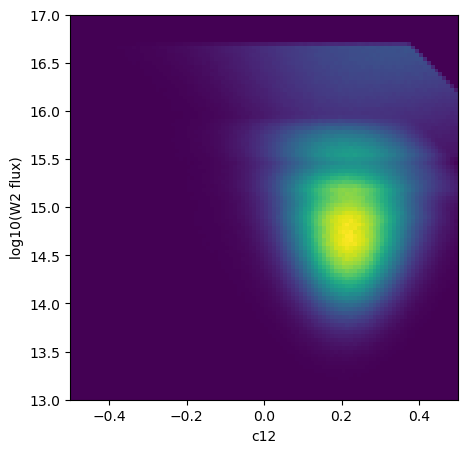

In [11]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.hist2d(masked_c12,mag_Lw2,bins=100,range=((-0.5,0.5),(13,17)));
ax.set_xlabel('c12')
ax.set_ylabel('log10(W2 flux)')

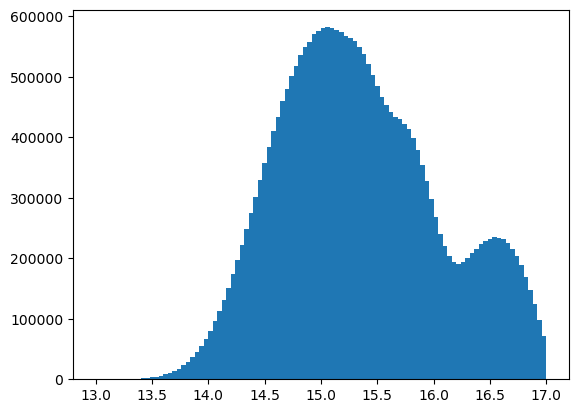

In [12]:
plt.hist(mag_Lw1,range=(13,17),bins=100)
plt.show()

### cuts in the diagram

The upper limit at 16.7 mag_w2  corresponds to the w2 flux cut in th blue sample, and the upper right diagonal probably corresponds to the w1 cut.

The recurring pattern with horizontal strips corresponds to 1 objects for each pixel, and 2, 3, 4.

In [13]:
mask_path = '/mnt/d/data_large/unwise_sz/unwiseplanck/combined_mask/total_mask_noapo_bool.fits'

maskPlanckWise = hp.read_map(mask_path).astype(bool)

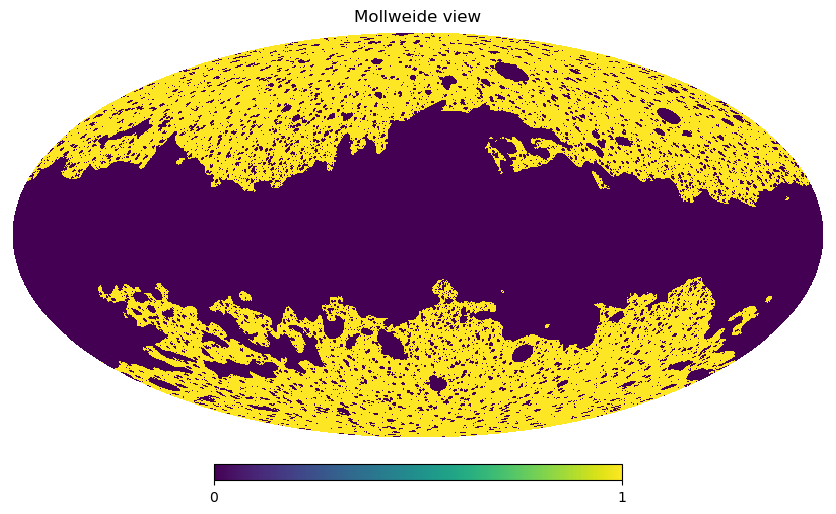

In [14]:
# print(masked_Lw1[:100])
hp.mollview(maskPlanckWise)

In [15]:
from assets import deprojection_index

ymap_name_list,ymap_path_list = deprojection_index.get_ymap_index_planck(2)

# load the default ymap with CIB dbetadT deprojection
ymap = hp.read_map(ymap_path_list[0])

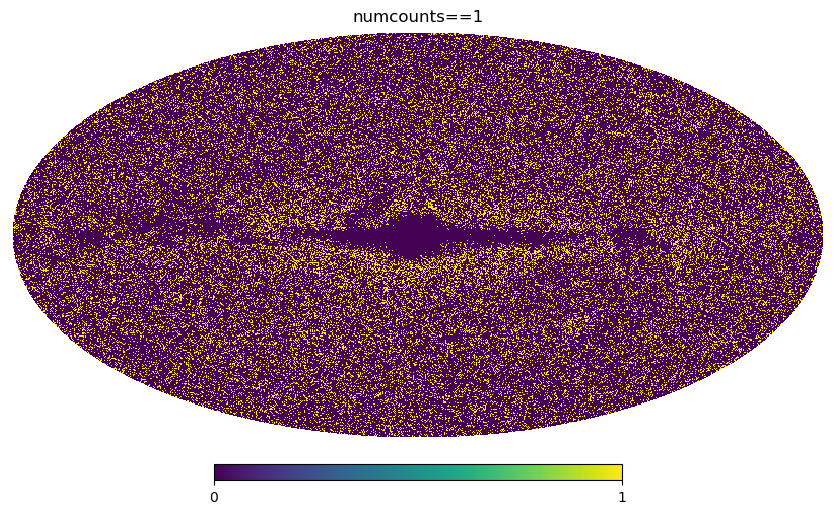

In [16]:
# plt.hist(numcounts[maskPlanckWise],bins=10,log=True)
hp.mollview(numcounts==1, title='numcounts==1')

In [17]:
maske_sample = maskPlanckWise & (numcounts==1)

sample_LW1 = flux_w1[maske_sample]
sample_LW2 = flux_w2[maske_sample]
sample_c12 = c12[maske_sample]
sample_ymap = ymap[maske_sample]

sample_mag_LW1 = 22.5-2.5*np.log10(sample_LW1)
sample_mag_LW2 = 22.5-2.5*np.log10(sample_LW2)

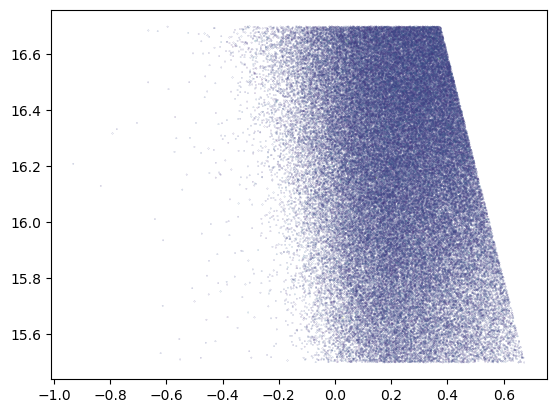

In [18]:
colors = (sample_ymap-np.min(sample_ymap))/(np.max(sample_ymap)-np.min(sample_ymap))
plt.scatter(sample_c12[:100000],sample_mag_LW2[:100000],c=colors[:100000],s=0.01,cmap='viridis')

In [19]:
def bilinear_model(x1,x2,a,b,c):
    return a*x1 + b*x2 + c

def log_probability(theta, x1, x2, y):
    a, b, c = theta
    model = bilinear_model(x1, x2, a, b, c)
    # sigma = 0.1
    return 0.5 * np.sum((y - model) ** 2)

from scipy.optimize import minimize

x1 = sample_c12
x2 = sample_mag_LW2
y = sample_ymap

initial = np.array([1E-7, 1E-7, 1E-7])

soln = minimize(log_probability, initial, args=(x1, x2, y))

a_ml, b_ml, c_ml = soln.x

print("Maximum likelihood estimates:")
print("a = {}".format(a_ml))
print("b = {}".format(b_ml))
print("c = {}".format(c_ml))

Maximum likelihood estimates:
a = 9.865860865801644e-08
b = -4.6067203546919096e-09
c = 9.39715826087432e-08


In [21]:
model_prediction = bilinear_model(x1,x2,a_ml,b_ml,c_ml)

covariance_matrix = soln.hess_inv


# cov = soln.hess_inv
# print(cov)
# print(log_probability([a_ml,b_ml,c_ml],x1,x2,y))
# # compare model prediction with ymap

# plt.scatter(y,model_prediction,s=0.01)
